# XGBoost Models | with feature selection

**XGBRegressor**

Josie Donnelly

*Last updated 11.02.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_loc_data_new_vars2.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df_orig


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093


In [3]:
df_orig.columns


Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [4]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'TEMP', 'CHLA']]
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

# add a column for the day of the year in radians
df.insert(loc=list(df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in df['date']])

# consider only the observations for which the target CHLA is available
df = df[~df['CHLA'].isna()].reset_index(drop=True)
df


,float,cycleNumber,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [5]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

## Create a train-test split grouping by float and cycle

In [13]:
df.insert(loc=list(df.columns).index('cycleNumber')+1, column='float_cycle_id', value=[f'{df.loc[i,"float"]}_{df.loc[i,"cycleNumber"]}'for i in range(df.shape[0])])
df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [15]:
print(f'Number of float-cycle pairs: {len(np.unique(df["float_cycle_id"]))}')


Number of float-cycle pairs: 58450


In [19]:
# split data indices into train and test dataframes grouped by float_cycle_id
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
split = splitter.split(df, groups=df['float_cycle_id'])
train_inds, test_inds = next(split)


In [21]:
print(f'Number of train observations: {len(train_inds)}')
print(f'Number of float-cycle observations: {len(test_inds)}')


Number of train observations: 26456594
Number of float-cycle observations: 6620402


In [26]:
train_df = df.loc[train_inds]
train_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076554,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,953,6.339257,1.978669e-18
33076555,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,955,6.319870,1.978669e-18
33076556,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,964,6.308070,1.978669e-18
33076557,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,966,6.296271,1.978669e-18


In [27]:
test_df = df.loc[test_inds]
test_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
1411,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,3,12.451333,1.445162e+00
1412,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,4,12.451333,1.445162e+00
1413,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,6,12.452000,1.441414e+00
1414,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,8,12.453667,1.433294e+00
1415,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,10,12.455333,1.398625e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [28]:
# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique(train_df['float_cycle_id'])
test_float_cycles = np.unique(test_df['float_cycle_id'])
print(f'Number of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of unique train float-cycles: 46760
Number of unique test float-cycles: 11690
Number of float-cycle pairs in both train and test sets: 0


## Define functions

In [33]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(group_df, depth_bin):
       
    group_data_df = group_df[group_df['depth_bin'] == depth_bin]
    group_data_df = group_data_df.drop(columns=['float', 'cycleNumber', 'float_cycle_id', 'date', 'PRES', 'depth_bin', 'TEMP'])

    return group_data_df


In [34]:
def standardize(train_data_df, test_data_df):
        
    X_train = train_data_df.drop(columns='CHLA')
    y_train = train_data_df['CHLA']
    X_test = test_data_df.drop(columns='CHLA')
    y_test = test_data_df['CHLA']

    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    return X_train, X_test, y_train, y_test
          

In [35]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [36]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=5):  
    plt.subplot((len(bins)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    plt.title(f'{bins[depth_idx]}m to {bins[depth_idx+1]}m', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend()
    

## XGB regressor at varying depths

In [29]:
# define depth bins
max_depth = max(df['PRES'])
interval = 20
bins = np.arange(0, max_depth + interval, interval)
bins[-2] = bins[-1]
bins = bins[:-1]     # absporbing the deepest bin into the second deepest bin because there are so few observations

depth_bins = pd.cut(df['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)


In [30]:
try:
    train_df = train_df.drop(columns='depth_bin')
except:
    pass

train_df.insert(loc=list(train_df.columns).index('PRES')+1, column='depth_bin', value=depth_bins)
train_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,depth_bin,TEMP,CHLA
0,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,3,0,12.378333,6.958747e-01
1,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,4,0,12.378333,6.958747e-01
2,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,6,0,12.378667,6.964993e-01
3,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,8,0,12.379000,7.164887e-01
4,1902303,1,1902303_1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.61,0.000306,27.891998,0.0357,10,0,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076554,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,953,47,6.339257,1.978669e-18
33076555,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,955,47,6.319870,1.978669e-18
33076556,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,964,48,6.308070,1.978669e-18
33076557,7901001,27,7901001_27,17.316,-23.379,2022-05-18 11:27:00,2.373934,0.136086,23.66,0.000018,58.424000,0.0122,966,48,6.296271,1.978669e-18


In [31]:
try:
    test_df = test_df.drop(columns='depth_bin')
except:
    pass

test_df.insert(loc=list(test_df.columns).index('PRES')+1, column='depth_bin', value=depth_bins)
test_df


,float,cycleNumber,float_cycle_id,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,depth_bin,TEMP,CHLA
1411,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,3,0,12.451333,1.445162e+00
1412,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,4,0,12.451333,1.445162e+00
1413,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,6,0,12.452000,1.441414e+00
1414,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,8,0,12.453667,1.433294e+00
1415,1902303,4,1902303_4,48.794,-14.689,2021-05-08 22:42:52,2.201910,0.694757,12.639999,0.000136,54.299999,0.0486,10,0,12.455333,1.398625e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,968,48,6.358057,-3.686869e-05
33076992,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,975,48,6.346782,-1.843434e-05
33076993,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,977,48,6.346782,2.543358e-18
33076994,7901001,28,7901001_28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705000,0.000142,59.995998,0.0122,982,49,6.346782,2.543358e-18


In [45]:
# initialize dataframe to store results
results_df = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])


DEPTH 0: 0m to 20m
	Num train samples: 749915  |  Num test samples: 187937
	Train MSE: 0.0243  |  Train r2: 0.9500
	Test MSE: 0.1840   |  Test r2: 0.6417

DEPTH 1: 20m to 40m
	Num train samples: 760312  |  Num test samples: 190497
	Train MSE: 0.0458  |  Train r2: 0.9008
	Test MSE: 0.1947   |  Test r2: 0.6105

DEPTH 2: 40m to 60m
	Num train samples: 760214  |  Num test samples: 190417
	Train MSE: 0.0342  |  Train r2: 0.8658
	Test MSE: 0.1158   |  Test r2: 0.5473

DEPTH 3: 60m to 80m
	Num train samples: 759341  |  Num test samples: 190278
	Train MSE: 0.0170  |  Train r2: 0.8655
	Test MSE: 0.0557   |  Test r2: 0.5243

DEPTH 4: 80m to 100m
	Num train samples: 756517  |  Num test samples: 189505
	Train MSE: 0.0094  |  Train r2: 0.8382
	Test MSE: 0.0288   |  Test r2: 0.4943

DEPTH 5: 100m to 120m
	Num train samples: 730495  |  Num test samples: 183073
	Train MSE: 0.0046  |  Train r2: 0.8194
	Test MSE: 0.0136   |  Test r2: 0.4621

DEPTH 6: 120m to 140m
	Num train samples: 731057  |  Num test 

/var/folders/9p/2w26l_q932bbph2rfc83837c0000gn/T/ipykernel_10981/1552663737.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


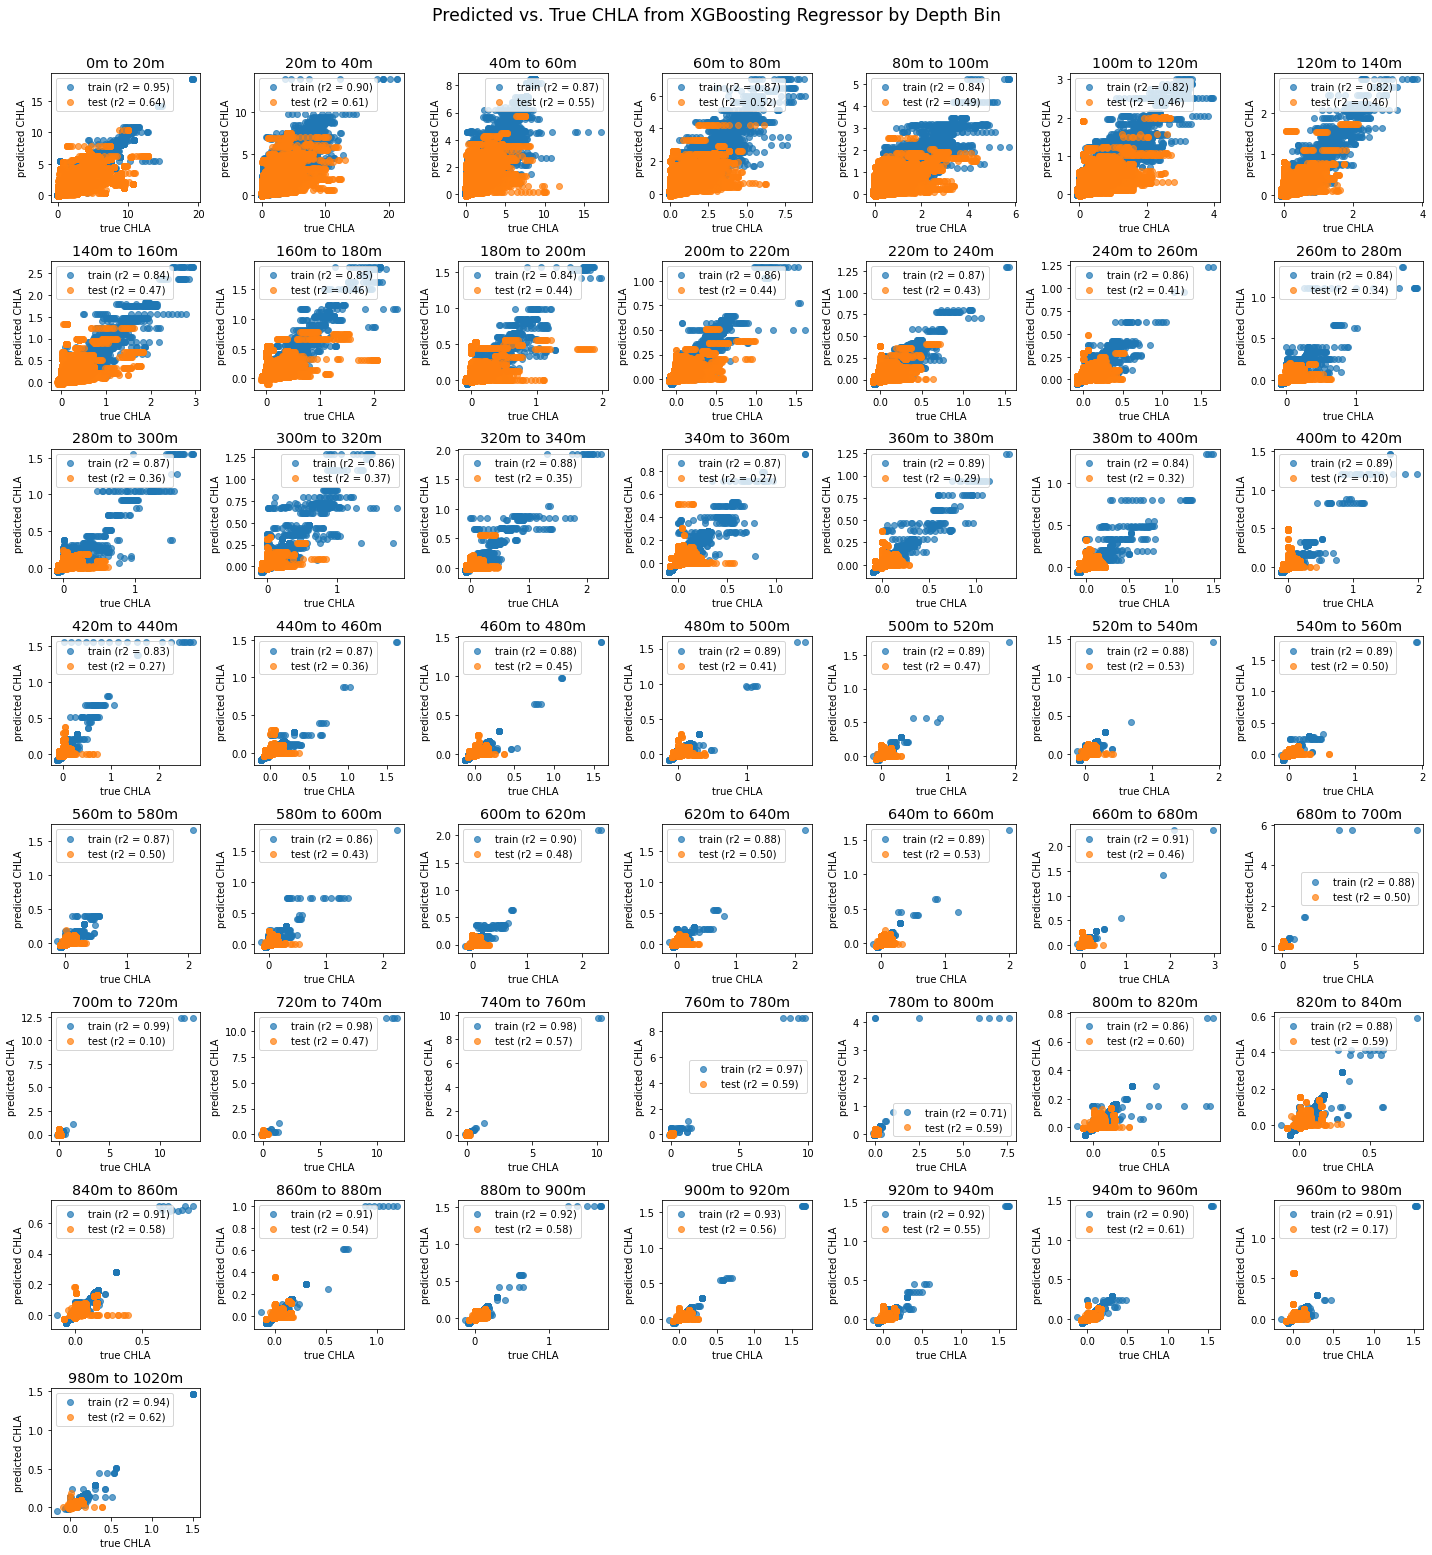

In [46]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(20,22))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {bins[depth_idx]}m to {bins[depth_idx+1]}m')
    
    # obtain train and test data for this bin
    train_data_df = get_data_by_depth(train_df, depth_bin=depth_idx)
    test_data_df = get_data_by_depth(test_df, depth_bin=depth_idx)

    # standardize features based on training data
    X_train, X_test, y_train, y_test = standardize(train_data_df, test_data_df)
        
    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=50, max_depth=10, colsample_bytree=0.8)     # grow_policy = 'depthwise' or 'lossguide'
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=7)
    
    # add scores to results dataframe
    results_df.loc[results_df.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]

    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


## Display XGBoost regressor results

In [47]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
print(f'\nMaximum train r2: {np.max(results_df["train_r2"])}')
print(f'Maximum test r2: {np.max(results_df["test_r2"])}')
results_df

Average train r2: 0.8826088932808993
Average test r2: 0.45802634040994744

Maximum train r2: 0.9852159568773389
Maximum test r2: 0.641725785634111


,depth_idx,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 20)",937852,0.024275,0.950000,0.184019,0.641726
1,1,"(20, 40)",950809,0.045804,0.900830,0.194708,0.610451
2,2,"(40, 60)",950631,0.034231,0.865838,0.115761,0.547311
3,3,"(60, 80)",949619,0.017040,0.865519,0.055720,0.524264
4,4,"(80, 100)",946022,0.009356,0.838159,0.028778,0.494296
5,5,"(100, 120)",913568,0.004611,0.819426,0.013604,0.462131
6,6,"(120, 140)",914138,0.002430,0.821919,0.006590,0.461261
7,7,"(140, 160)",911918,0.001368,0.837879,0.004293,0.466355
8,8,"(160, 180)",911336,0.000756,0.846213,0.002727,0.464607
9,9,"(180, 200)",911642,0.000438,0.842646,0.001634,0.435873


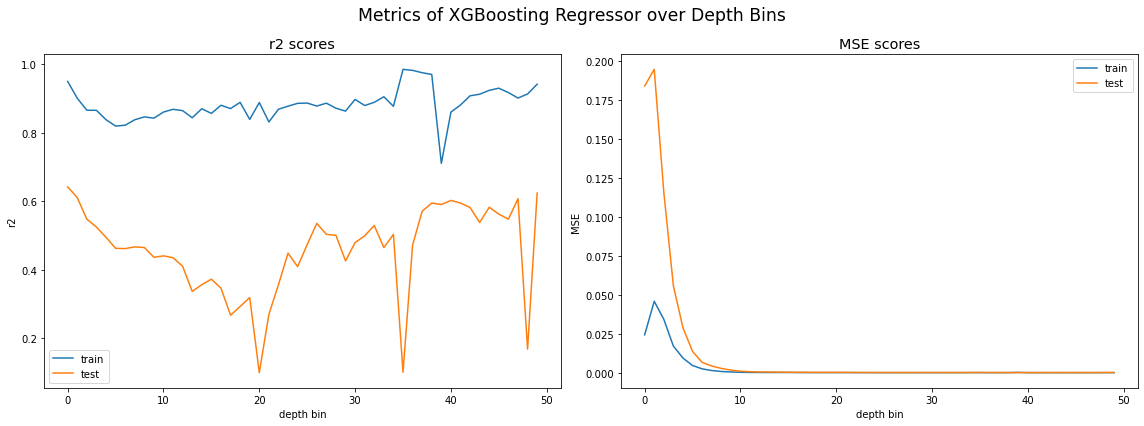

In [48]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
results_df.to_csv('results_xgb_feature_selection_ejd.csv', index=False)
